In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy import stats
import researchpy as rp
from wordcloud import WordCloud, STOPWORDS 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [3]:
columns = ['cord_uid', 'who_covidence_id', 'sha', 'title', 'license', 'publish_time', 'journal', 'authors', 'url' ,'pdf_json_files']
path = 'C:/Users/HP/Desktop/arc/cord_19_embeddings/metadata.csv'
meta_df = pd.read_csv(path, usecols = columns, low_memory = False, dtype = {'who_covidence_id': str, 'pdf_json_files':str})

In [4]:
print(meta_df.head())

   cord_uid                                       sha  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32   

                                               title license publish_time  \
0  Clinical features of culture-proven Mycoplasma...   no-cc   2001-07-04   
1  Nitric oxide: a pro-inflammatory mediator in l...   no-cc   2000-08-15   
2    Surfactant protein-D and pulmonary host defense   no-cc   2000-08-25   
3               Role of endothelin-1 in lung disease   no-cc   2001-02-22   
4  Gene expression in epithelial cells in respons...   no-cc   2001-05-11   

                                             authors         journal  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis   
1  Vliet, Albert van der; Eiserich, Jason P; Cros.

In [5]:
print(meta_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341713 entries, 0 to 341712
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   cord_uid          341713 non-null  object
 1   sha               121365 non-null  object
 2   title             341563 non-null  object
 3   license           341713 non-null  object
 4   publish_time      341370 non-null  object
 5   authors           330566 non-null  object
 6   journal           320729 non-null  object
 7   who_covidence_id  121970 non-null  object
 8   pdf_json_files    121365 non-null  object
 9   url               221145 non-null  object
dtypes: object(10)
memory usage: 26.1+ MB
None


In [6]:
print(meta_df.isnull().sum())
print("number of paper that has title out of " + str(len(meta_df)) + " : " + str((len(meta_df)-(meta_df.title.isnull().sum()))))

cord_uid                 0
sha                 220348
title                  150
license                  0
publish_time           343
authors              11147
journal              20984
who_covidence_id    219743
pdf_json_files      220348
url                 120568
dtype: int64
number of paper that has title out of 341713 : 341563


In [7]:
print("number of distinct paper id : " + str(meta_df.sha.nunique()))
print("number of distinct title : " + str(meta_df.title.nunique()))

number of distinct paper id : 121358
number of distinct title : 282557


In [8]:
# articles with null title
print(meta_df[meta_df['title'].isnull()]['title'])

35003     NaN
35048     NaN
36110     NaN
36250     NaN
37149     NaN
         ... 
241051    NaN
250435    NaN
257410    NaN
281640    NaN
314404    NaN
Name: title, Length: 150, dtype: object


In [9]:
all_json = os.listdir('C:/Users/HP/Desktop/arc/document_parses/pdf_json')
path = 'C:/Users/HP/Desktop/arc/document_parses/pdf_json'
print(len(all_json))

128915


In [10]:
import random
random_papers = random.sample(range(128915), 40000)
raw_json = []
#meta_list = []
for i in random_papers:
	with open(os.path.join(path, all_json[i])) as js:
		j = json.load(js)
		paper_id = j['paper_id']
		title = j['metadata']['title']
		try:
			abstract = j['abstract'][0]['text']
		except:
			abstract = ""
		full_text = ""
		bib_entries = []
		for text in j['body_text']:
			full_text += text['text']
			for csp in text['cite_spans']:
				try:
					title = j['bib_entries'][csp['ref_id']]['title']
					bib_entries.append(title)
				except:
					pass
		raw_json.append([paper_id, title, abstract, full_text, bib_entries])
		#meta_data = meta_df.loc[meta_df['sha'] == paper_id]
		#meta_list.append(meta_data)

In [11]:
df=pd.DataFrame(raw_json,columns=['paper_id','title','abstract','body','bib_entries']) 
#print(df['list_authors'])
#df.to_csv('new.csv')
#metadf = pd.DataFrame(meta_list, columns=columns)
meta_df.rename(columns = {'sha':'paper_id'}, inplace = True)
df = pd.merge(df, meta_df, how='inner', on= 'paper_id')
df.head()

,paper_id,title_x,abstract,body,bib_entries,cord_uid,title_y,license,publish_time,authors,journal,who_covidence_id,pdf_json_files,url
0,fb048d4250c6ef602d310686f95071f3b9bd3f59,Renin-angiotensin system in human coronavirus ...,The coronavirus disease 2019 caused by SARS-Co...,The coronavirus disease 2019 (COVID-19) caused...,[A crucial role of angiotensin converting enzy...,yxjmh8sn,Cell type-specific expression of the putative ...,no-cc,2020-04-15,"Nicin, Luka; Abplanalp, Wesley Tyler; Mellenti...",Eur Heart J,NaN,document_parses/pdf_json/fb048d4250c6ef602d310...,https://www.ncbi.nlm.nih.gov/pubmed/32293672/;...
1,49a3a223b6b40c1bf6d9d83db3b37b93f1621bec,Strongyloides stercoralis hyperinfection syndr...,An increasing number of critically ill patient...,The proportion of critically ill patients with...,[Acute respiratory failure in immunocompromise...,rsgi1dtu,Diagnosis of severe respiratory infections in ...,no-cc,2020-02-07,"Azoulay, Elie; Russell, Lene; Van de Louw, And...",Intensive Care Med,NaN,document_parses/pdf_json/49a3a223b6b40c1bf6d9d...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
2,7d679914c9cfab4d1f610a9d7fcc1eb3d3f01d6d,Identification and localization of ERD2 in the...,Human erythrocytes infected with the malarialp...,The Golgi apparatus plays a pivotal role in th...,[Biosynthetic protein transport and sorting by...,lb6bvo5r,Recognition of a 170 kD protein in mammalian G...,no-cc,2005-11-05,"Li, Wenlu; Keller, Gilbert-André; Haldar, Kasturi",Tissue Cell,NaN,document_parses/pdf_json/7d679914c9cfab4d1f610...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
3,ae27cfdd3c9af7faba38c4cfc6016638e4867545,Trends in interest of covid-19 on polish internet,Our task is to examine the relationship betwee...,The optimal way to cope with SARS-CoV-2 global...,[Social values are significant factors in cont...,3qhpu7v0,An attempt to optimize human resources allocat...,medrxiv,2020-10-15,"Jarynowski, A.; Wojta-Kempa, M.; Krzowski, L.",NaN,NaN,document_parses/pdf_json/ae27cfdd3c9af7faba38c...,http://medrxiv.org/cgi/content/short/2020.10.1...
4,b1c4f7252d233cc6ed95ed1b79cec9b259a2ad9d,Harnessing innate immunity in cancer therapy,The relationship between severe acute respirat...,Severe Acute Respiratory Syndrome Coronavirus-...,"[WHO Coronavirus Disease (COVID-19) Dashboard,...",s9vgox15,Unique immunological profile in patients with ...,cc-by,2020-10-15,"Varchetta, Stefania; Mele, Dalila; Oliviero, B...",Cell Mol Immunol,NaN,document_parses/pdf_json/b1c4f7252d233cc6ed95e...,https://doi.org/10.1038/s41423-020-00557-9; ht...


In [12]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

In [13]:
df['body'] = df['body'].apply(lambda x: lower_case(x))
df['abstract'] = df['abstract'].apply(lambda x: lower_case(x))
df['body'].head()

0    the coronavirus disease 2019 (covid-19) caused...
1    the proportion of critically ill patients with...
2    the golgi apparatus plays a pivotal role in th...
3    the optimal way to cope with sars-cov-2 global...
4    severe acute respiratory syndrome coronavirus-...
Name: body, dtype: object

In [14]:
incubation = df[df['body'].str.contains('incubation')]
incubation.head()

,paper_id,title_x,abstract,body,bib_entries,cord_uid,title_y,license,publish_time,authors,journal,who_covidence_id,pdf_json_files,url
7,0479ff4e73538d4c888c88577048ab1055bce66f,Nine challenges in incorporating the dynamics ...,,mathematical models play an increasingly impor...,[Infectious Diseases of Humans: Dynamics and C...,tysa2b5x,How Modelling Can Enhance the Analysis of Impe...,no-cc,2019-02-06,"Cauchemez, Simon; Hoze, Nathanaël; Cousien, An...",Trends Parasitol,NaN,document_parses/pdf_json/0479ff4e73538d4c888c8...,https://doi.org/10.1016/j.pt.2019.01.009; http...
8,89da54123ba1ef030869fd671971dd907fc7feae,Fabrication of fillable microparticles and oth...,engineering vaccine-based therapeutics for inf...,infectious diseases are caused by a variety of...,"[The Vaccines, Live attenuated vaccines: histo...",pux58dut,Engineering DNA vaccines against infectious di...,no-cc,2018-10-15,"Lee, Jihui; Arun Kumar, Shreedevi; Jhan, Yong ...",Acta Biomater,NaN,document_parses/pdf_json/89da54123ba1ef030869f...,https://api.elsevier.com/content/article/pii/S...
14,83cc47c1025589aa294770b99cad13c4d31f956d,A data driven epidemic model to analyse the lo...,the role of mathematical modelling in predicti...,"transmitting rate [19] .in this work, a varian...",[Preliminary analysis of COVID-19 spread in It...,4xce93g8,Predictive Analysis for COVID-19 Spread in Ind...,medrxiv,2020-07-09,"Singh, S. S.; Mohapatra, D.",NaN,NaN,document_parses/pdf_json/83cc47c1025589aa29477...,http://medrxiv.org/cgi/content/short/2020.07.0...
15,92a4cbcc55d992b5fd6f9c77de0fb4f5030a566a,SNAREpins: minimal machinery for membrane fusion,"we tested the role of the ""spring-loaded"" conf...","we tested the role of the ""spring-loaded"" conf...","[Viruscell and cell-cell fusion, A spring-load...",78fjem8s,Specific Single or Double Proline Substitution...,cc-by-nc-sa,1998-06-15,"Qiao, Hui; Pelletier, Sandra L.; Hoffman, Luca...",J Cell Biol,NaN,document_parses/pdf_json/92a4cbcc55d992b5fd6f9...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
23,b67dbe76dee8f74e54ca42605b12ee1614b82c73,Manifestations extra-pulmonaires des lgionelloses,,"and even protozoa. among atypical bacteria, ch...",[What does the future hold for clinical microb...,lsvlmw01,Acute Pneumonia and Importance of Atypical Bac...,no-cc,2006,"Boyadjiev, I.; Léone, M.; Martin, C.",Intensive Care Medicine,NaN,document_parses/pdf_json/b67dbe76dee8f74e54ca4...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...


In [15]:
all_incubation_paragraph=[]
for text in incubation['body'].values:
    for paragraph in text.split('. '):
        if 'incubation' in paragraph:
            all_incubation_paragraph.append(paragraph)

print("len incubation paragraph: " + str(len(all_incubation_paragraph)))

len incubation paragraph: 15216


In [16]:
virus = df[df['body'].str.contains('virus')]
virus.head()

,paper_id,title_x,abstract,body,bib_entries,cord_uid,title_y,license,publish_time,authors,journal,who_covidence_id,pdf_json_files,url
0,fb048d4250c6ef602d310686f95071f3b9bd3f59,Renin-angiotensin system in human coronavirus ...,the coronavirus disease 2019 caused by sars-co...,the coronavirus disease 2019 (covid-19) caused...,[A crucial role of angiotensin converting enzy...,yxjmh8sn,Cell type-specific expression of the putative ...,no-cc,2020-04-15,"Nicin, Luka; Abplanalp, Wesley Tyler; Mellenti...",Eur Heart J,NaN,document_parses/pdf_json/fb048d4250c6ef602d310...,https://www.ncbi.nlm.nih.gov/pubmed/32293672/;...
1,49a3a223b6b40c1bf6d9d83db3b37b93f1621bec,Strongyloides stercoralis hyperinfection syndr...,an increasing number of critically ill patient...,the proportion of critically ill patients with...,[Acute respiratory failure in immunocompromise...,rsgi1dtu,Diagnosis of severe respiratory infections in ...,no-cc,2020-02-07,"Azoulay, Elie; Russell, Lene; Van de Louw, And...",Intensive Care Med,NaN,document_parses/pdf_json/49a3a223b6b40c1bf6d9d...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
3,ae27cfdd3c9af7faba38c4cfc6016638e4867545,Trends in interest of covid-19 on polish internet,our task is to examine the relationship betwee...,the optimal way to cope with sars-cov-2 global...,[Social values are significant factors in cont...,3qhpu7v0,An attempt to optimize human resources allocat...,medrxiv,2020-10-15,"Jarynowski, A.; Wojta-Kempa, M.; Krzowski, L.",NaN,NaN,document_parses/pdf_json/ae27cfdd3c9af7faba38c...,http://medrxiv.org/cgi/content/short/2020.10.1...
4,b1c4f7252d233cc6ed95ed1b79cec9b259a2ad9d,Harnessing innate immunity in cancer therapy,the relationship between severe acute respirat...,severe acute respiratory syndrome coronavirus-...,"[WHO Coronavirus Disease (COVID-19) Dashboard,...",s9vgox15,Unique immunological profile in patients with ...,cc-by,2020-10-15,"Varchetta, Stefania; Mele, Dalila; Oliviero, B...",Cell Mol Immunol,NaN,document_parses/pdf_json/b1c4f7252d233cc6ed95e...,https://doi.org/10.1038/s41423-020-00557-9; ht...
5,54deb3ee4cd9b724213f3b261fed3f4d0778313d,Pulmonary Therapy 2020 Update and Podcast: Mee...,the editors-in-chief of pulmonary therapy have...,recorded a podcast highlighting their current ...,[],efgozm3d,Pulmonary Therapy 2020 Update and Podcast: Mee...,cc-by-nc,2020-04-09,"Beeh, Kai-Michael; Dhand, Rajiv",Pulm Ther,NaN,document_parses/pdf_json/54deb3ee4cd9b724213f3...,https://doi.org/10.1007/s41030-020-00114-9; ht...


In [17]:
all_virus_paragraph=[]
for text in virus['body'].values:
    for paragraph in text.split('. '):
        if 'virus' in paragraph:
            all_virus_paragraph.append(paragraph)

print("len virus paragraph: " + str(len(all_virus_paragraph)))

len virus paragraph: 348786


In [18]:
days_incubation=[]
for t in all_incubation_paragraph:
    day=re.findall(r"\d{1,2} day", t)
    if (len(day)==1):
        days_incubation.append(day[0].split(" "))
        
days_incubation_1=[]

for d in days_incubation:
    days_incubation_1.append(float(d[0]))

print("len days incubation: " + str(len(days_incubation_1)))

len days incubation: 1708


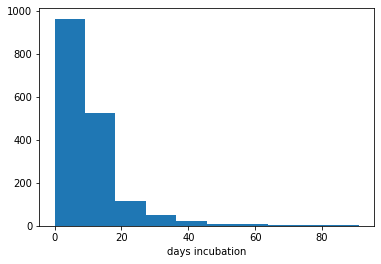

In [19]:
plt.xlabel("days incubation")
plt.hist(days_incubation_1)
plt.show()

In [20]:
print("mean incubation: " + str(np.mean(days_incubation_1)))

mean incubation: 10.802693208430913


In [21]:
transmission = df[df['body'].str.contains('transmission')]
all_transmission_paragraph=[]
for text in transmission['body'].values:
    for paragraph in text.split('. '):
        if 'transmission' in paragraph:
            all_transmission_paragraph.append(paragraph)

In [22]:
print("len all_transmission_paragraph: " + str(len(all_transmission_paragraph)))

len all_transmission_paragraph: 56531


In [23]:
feet_transmission=[]
for t in all_transmission_paragraph:
    feet = re.findall(r"\d{1,2} feet", t)
    if len(feet)==1:
        feet_transmission.append(feet)

In [24]:
feet_transmission_1=[]
for d in feet_transmission:
    feet_transmission_1.append(float(d[0].split(' ')[0]))
    
print("len feet_transmission: " + str(len(feet_transmission_1)))

len feet_transmission: 45


In [25]:
print("mean feet_transmission: " + str(np.mean(feet_transmission_1)))

mean feet_transmission: 6.266666666666667


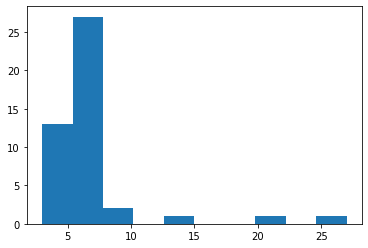

In [26]:
plt.hist(feet_transmission_1)
plt.show()

In [27]:
#df['word_count'] = df['full_text'].apply(lambda x: len(str(x).split(" ")))
#df['char_count'] = df['full_text'].str.len() ## this also includes spaces
#print(df.head())

df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df['body_word_count'] = df['body'].apply(lambda x: len(x.strip().split()))  # word count in body
df['body_unique_words']=df['body'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df.head()

,paper_id,title_x,abstract,body,bib_entries,cord_uid,title_y,license,publish_time,authors,journal,who_covidence_id,pdf_json_files,url,abstract_word_count,body_word_count,body_unique_words
0,fb048d4250c6ef602d310686f95071f3b9bd3f59,Renin-angiotensin system in human coronavirus ...,the coronavirus disease 2019 caused by sars-co...,the coronavirus disease 2019 (covid-19) caused...,[A crucial role of angiotensin converting enzy...,yxjmh8sn,Cell type-specific expression of the putative ...,no-cc,2020-04-15,"Nicin, Luka; Abplanalp, Wesley Tyler; Mellenti...",Eur Heart J,NaN,document_parses/pdf_json/fb048d4250c6ef602d310...,https://www.ncbi.nlm.nih.gov/pubmed/32293672/;...,296,726,348
1,49a3a223b6b40c1bf6d9d83db3b37b93f1621bec,Strongyloides stercoralis hyperinfection syndr...,an increasing number of critically ill patient...,the proportion of critically ill patients with...,[Acute respiratory failure in immunocompromise...,rsgi1dtu,Diagnosis of severe respiratory infections in ...,no-cc,2020-02-07,"Azoulay, Elie; Russell, Lene; Van de Louw, And...",Intensive Care Med,NaN,document_parses/pdf_json/49a3a223b6b40c1bf6d9d...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,213,6232,2041
2,7d679914c9cfab4d1f610a9d7fcc1eb3d3f01d6d,Identification and localization of ERD2 in the...,human erythrocytes infected with the malarialp...,the golgi apparatus plays a pivotal role in th...,[Biosynthetic protein transport and sorting by...,lb6bvo5r,Recognition of a 170 kD protein in mammalian G...,no-cc,2005-11-05,"Li, Wenlu; Keller, Gilbert-André; Haldar, Kasturi",Tissue Cell,NaN,document_parses/pdf_json/7d679914c9cfab4d1f610...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,199,4190,1302
3,ae27cfdd3c9af7faba38c4cfc6016638e4867545,Trends in interest of covid-19 on polish internet,our task is to examine the relationship betwee...,the optimal way to cope with sars-cov-2 global...,[Social values are significant factors in cont...,3qhpu7v0,An attempt to optimize human resources allocat...,medrxiv,2020-10-15,"Jarynowski, A.; Wojta-Kempa, M.; Krzowski, L.",NaN,NaN,document_parses/pdf_json/ae27cfdd3c9af7faba38c...,http://medrxiv.org/cgi/content/short/2020.10.1...,155,5970,1883
4,b1c4f7252d233cc6ed95ed1b79cec9b259a2ad9d,Harnessing innate immunity in cancer therapy,the relationship between severe acute respirat...,severe acute respiratory syndrome coronavirus-...,"[WHO Coronavirus Disease (COVID-19) Dashboard,...",s9vgox15,Unique immunological profile in patients with ...,cc-by,2020-10-15,"Varchetta, Stefania; Mele, Dalila; Oliviero, B...",Cell Mol Immunol,NaN,document_parses/pdf_json/b1c4f7252d233cc6ed95e...,https://doi.org/10.1038/s41423-020-00557-9; ht...,253,3282,1207


In [28]:
df['abstract'].describe(include='all')

count     35602
unique    24045
top            
freq      11248
Name: abstract, dtype: object

In [29]:
df['body'].describe(include='all')

count                                                 35602
unique                                                35561
top       the nuclear receptor heterodimers of liver x r...
freq                                                     24
Name: body, dtype: object

In [30]:
#df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35602 entries, 0 to 35601
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             35602 non-null  object
 1   title_x              35602 non-null  object
 2   abstract             35602 non-null  object
 3   body                 35602 non-null  object
 4   bib_entries          35602 non-null  object
 5   cord_uid             35602 non-null  object
 6   title_y              35601 non-null  object
 7   license              35602 non-null  object
 8   publish_time         35602 non-null  object
 9   authors              35074 non-null  object
 10  journal              31957 non-null  object
 11  who_covidence_id     0 non-null      object
 12  pdf_json_files       35602 non-null  object
 13  url                  35602 non-null  object
 14  abstract_word_count  35602 non-null  int64 
 15  body_word_count      35602 non-null  int64 
 16  body

count     35602.000000
mean       3843.277878
std        7139.881527
min           1.000000
25%        1397.000000
50%        2836.500000
75%        4582.000000
max      233918.000000
Name: body_word_count, dtype: float64

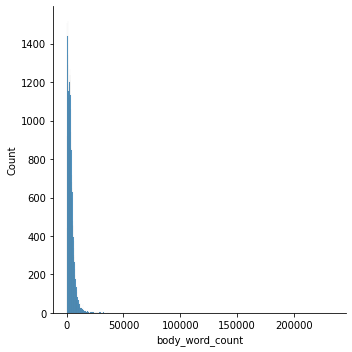

In [31]:
sns.displot(df['body_word_count'])
df['body_word_count'].describe()

count    35602.000000
mean      1167.191590
std       1198.385268
min          1.000000
25%        612.000000
50%       1001.000000
75%       1425.000000
max      32466.000000
Name: body_unique_words, dtype: float64

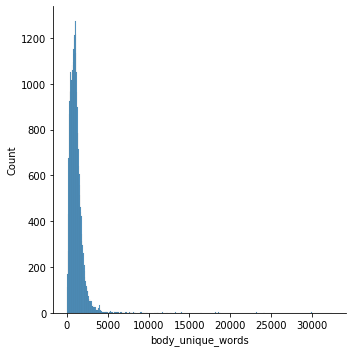

In [33]:
sns.displot(df['body_unique_words'])
df['body_unique_words'].describe()

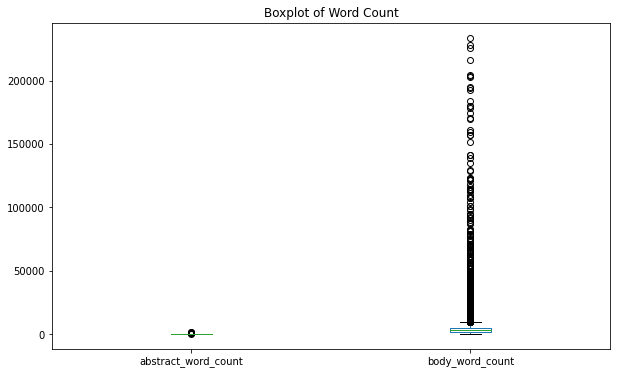

In [34]:
df[['abstract_word_count', 'body_word_count']].plot(kind='box', title='Boxplot of Word Count', figsize=(10,6))
plt.show()

In [35]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

In [36]:
df['avg_word'] = df['body'].apply(lambda x: avg_word(x))
print(df[['body','avg_word']].head())

                                                body  avg_word
0  the coronavirus disease 2019 (covid-19) caused...  5.658402
1  the proportion of critically ill patients with...  6.024230
2  the golgi apparatus plays a pivotal role in th...  5.449881
3  the optimal way to cope with sars-cov-2 global...  5.614908
4  severe acute respiratory syndrome coronavirus-...  5.614564


In [37]:
#stop is a list of all stop words in english
stop = stopwords.words('english')

In [38]:
#calculating number of stop words presents in body text of each paper
df['stopwords'] = df['body'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['body','stopwords']].head()

,body,stopwords
0,the coronavirus disease 2019 (covid-19) caused...,233
1,the proportion of critically ill patients with...,1988
2,the golgi apparatus plays a pivotal role in th...,1554
3,the optimal way to cope with sars-cov-2 global...,2103
4,severe acute respiratory syndrome coronavirus-...,1094


In [39]:
df['numerics'] = df['body'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['body','numerics']].head()

,body,numerics
0,the coronavirus disease 2019 (covid-19) caused...,15
1,the proportion of critically ill patients with...,31
2,the golgi apparatus plays a pivotal role in th...,73
3,the optimal way to cope with sars-cov-2 global...,51
4,severe acute respiratory syndrome coronavirus-...,60


In [40]:
#Removing all digits in the text
df['body'] = df['body'].apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
df['body'].head()

0    the coronavirus disease (covid-19) caused by s...
1    the proportion of critically ill patients with...
2    the golgi apparatus plays a pivotal role in th...
3    the optimal way to cope with sars-cov-2 global...
4    severe acute respiratory syndrome coronavirus-...
Name: body, dtype: object

In [41]:
#Removing punctuations
df['body'] = df['body'].str.replace('[^\w\s]','')
df['body'].head()

0    the coronavirus disease covid19 caused by sars...
1    the proportion of critically ill patients with...
2    the golgi apparatus plays a pivotal role in th...
3    the optimal way to cope with sarscov2 global p...
4    severe acute respiratory syndrome coronavirus2...
Name: body, dtype: object

In [42]:
#remove stopwords
df['body'] = df['body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['body'].head()

0    coronavirus disease covid19 caused sarscov2 in...
1    proportion critically ill patients deficient i...
2    golgi apparatus plays pivotal role biosyntheti...
3    optimal way cope sarscov2 global pandemic stil...
4    severe acute respiratory syndrome coronavirus2...
Name: body, dtype: object

In [43]:
df.to_csv('metadata_paper_combined.csv', index= False)

In [44]:
df = pd.read_csv('C:/Users/HP/Desktop/arc/metadata_paper_combined.csv')

In [45]:
df['numerics'].median()

37.0

In [46]:
df['numerics'].min()

0

In [47]:
df['numerics'].max()

7251

In [48]:
df['numerics'].mean()

62.493455423852595

In [49]:
norm_data = df['numerics']
print("Standard deviation of Numrics is: ",end="")  
print(norm_data.std())

print ("The varianve of the numeric is: ", end="")
print(norm_data.var())

Standard deviation of Numrics is: 159.06902713543062
The varianve of the numeric is: 25302.955393812357


In [50]:
# Deferencial
print(df['body_word_count'].min())
print (df['body_word_count'].max())

#infer
print(df['body_word_count'].median())
print(df['body_word_count'].mean())

norm_data = df['body_word_count']
print("Standard deviation of body word count is: ",end="")  
print(norm_data.std())

print ("The varianve of the body word count is: ", end="")
print(norm_data.var())

1
233918
2836.5
3843.2778776473233
Standard deviation of body word count is: 7139.881526791737
The varianve of the body word count is: 50977908.216621906


In [70]:
diff = df.body_word_count - df.body_unique_words

((array([-4.11369083, -3.90425472, -3.78992589, ...,  3.78992589,
          3.90425472,  4.11369083]),
  array([     0,      0,      0, ..., 195700, 200061, 204011], dtype=int64)),
 (2962.280929559765, 2676.08628728723, 0.4932998666518825))

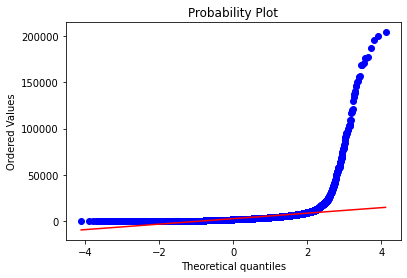

In [71]:
stats.probplot(diff, plot = plt)

In [72]:
stats.ttest_ind(df.body_word_count, df.body_unique_words)

Ttest_indResult(statistic=69.74506951208664, pvalue=0.0)

In [73]:
rp.summary_cont(df.groupby('publish_time')['body_word_count'])

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,N,Mean,SD,SE,95% Conf.,Interval
publish_time,,,,,,
1922,1,1060.0000,NaN,NaN,NaN,NaN
1955,1,734.0000,NaN,NaN,NaN,NaN
1964-01-01,1,1807.0000,NaN,NaN,NaN,NaN
1968,1,694.0000,NaN,NaN,NaN,NaN
1969,1,4141.0000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-01-31,2,8413.0000,6491.2403,4590.0000,-49908.4797,66734.4797
2021-02-01,1,4452.0000,NaN,NaN,NaN,NaN
2021-02-15,3,2723.3333,798.7499,461.1584,739.1287,4707.5380


In [75]:
df.avg_word.mean()

5.544490247595301

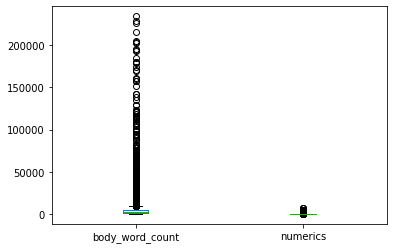

In [76]:
df[['body_word_count', 'numerics']].plot(kind='box')
plt.show()

In [77]:
df['publish_time'].corr(df['body_word_count'], method = 'spearman')

-0.20066107608954084

In [78]:
df['publish_time'].corr(df['numerics'], method = 'spearman')

-0.21787093001558677

In [79]:
df['publish_time'].corr(df['stopwords'], method = 'spearman')

-0.17499913896782543

In [80]:
df['abstract_word_count'].corr(df['body_word_count'], method = 'spearman')

0.39422903408372206

In [81]:
df['body_word_count'].corr(df['numerics'], method = 'spearman')

0.6915327848678813

In [82]:
df['body_word_count'].corr(df['stopwords'], method = 'spearman')

0.9664677932362993

In [83]:
df.stopwords.mean()

1340.3429020841527

In [84]:
df.numerics.mean()

62.493455423852595

In [85]:
df.numerics.mode()

0    8
dtype: int64

[153488, 212568, 236284, 48335, 218039, 254927, 34933, 212568, 78300, 97830, 225776, 123084, 59597, 74496, 37711, 144055, 76738, 200448, 41182, 15968, 48040, 94189, 37711, 135530, 38529, 155582, 33502, 88106, 53680, 168166, 62124]


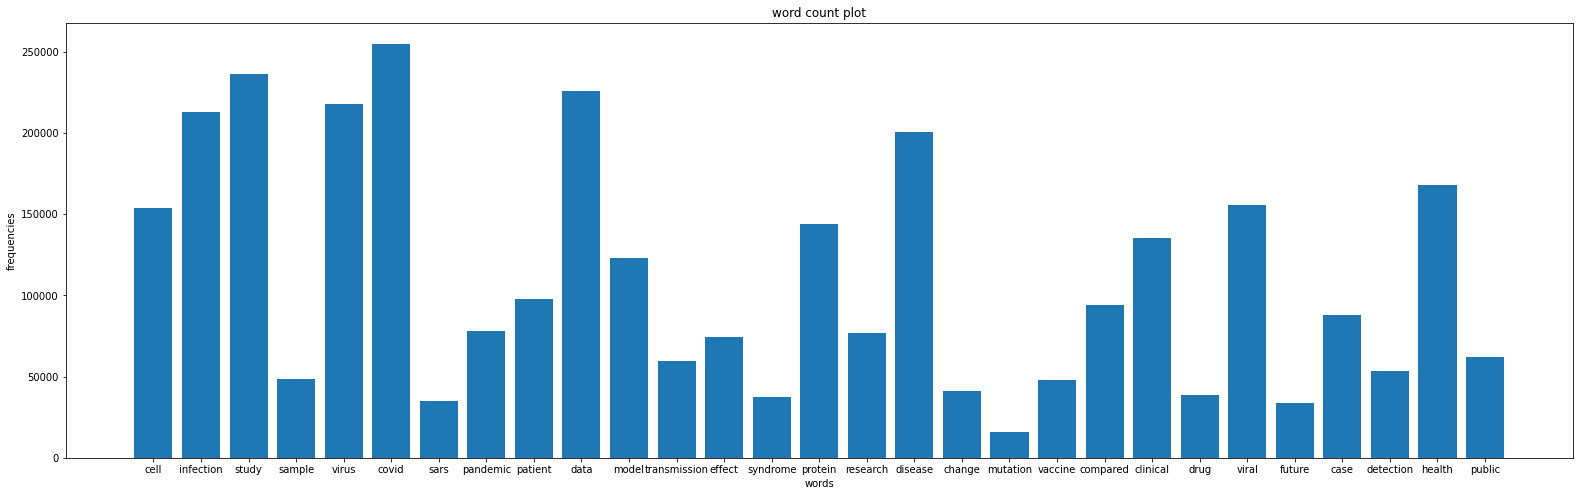

In [63]:
word_list = ['cell','infection', 'study', 'sample','virus', 'covid', 'sars', 'infection','pandemic','patient','data','model','transmission','effect','syndrome','protein','research','disease','change','mutation','vaccine','compared','syndrome','clinical','drug','viral','future','case','detection','health','public']
count = []
for i in word_list:
  count.append(tokenizer.word_counts[i])

print(count)

fig = plt.figure(figsize = (27, 8)) 
  
plt.bar(word_list, count)
plt.xlabel("words") 
plt.ylabel("frequencies") 
plt.title("word count plot") 
plt.show()

In [51]:
bodytext = []
for index, row in df.iterrows():
  bodytext.append(row['body'])

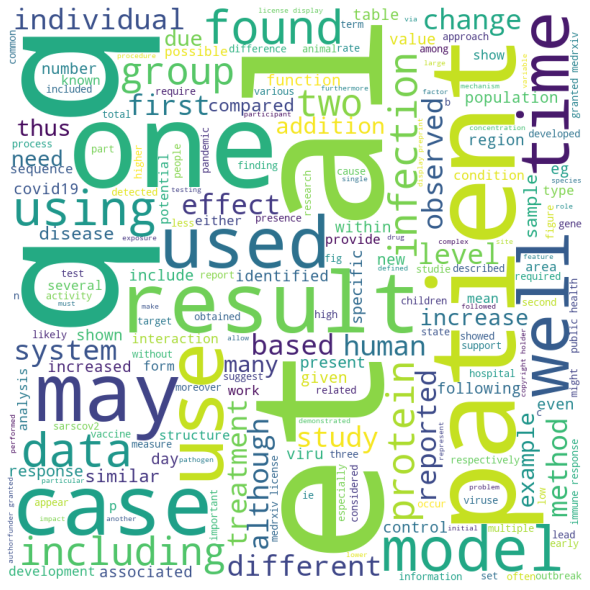

In [52]:
comment_words = '' 
stopwords = set(STOPWORDS) 
i = 0
for val in bodytext[:2000]: 
    val = str(val) 
    tokens = val.split()       
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

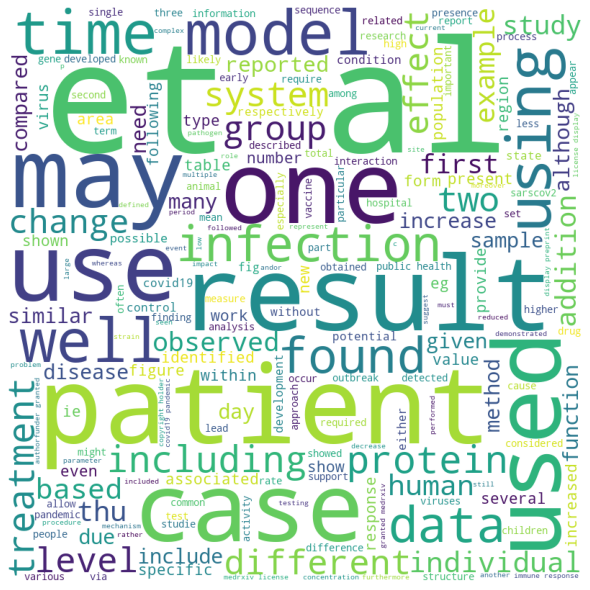

In [53]:
comment_words = '' 
i = 0
for val in bodytext[2000:4000]: 
    val = str(val) 
    tokens = val.split()       
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

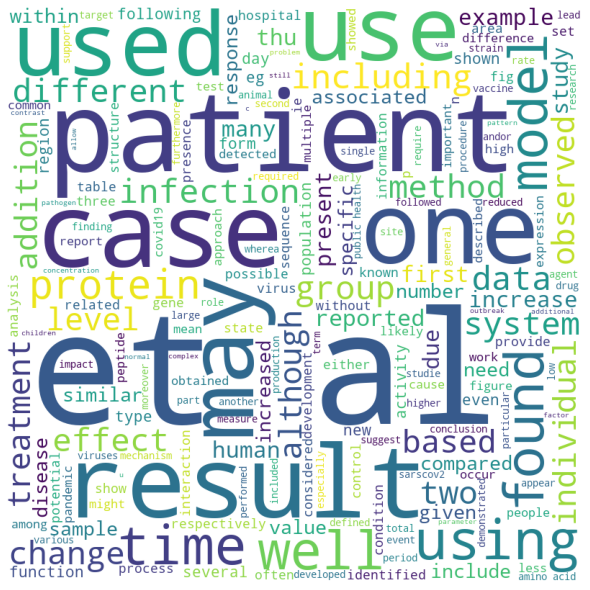

In [54]:
comment_words = '' 
i = 0
for val in bodytext[20000:22000]: 
    val = str(val) 
    tokens = val.split()       
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

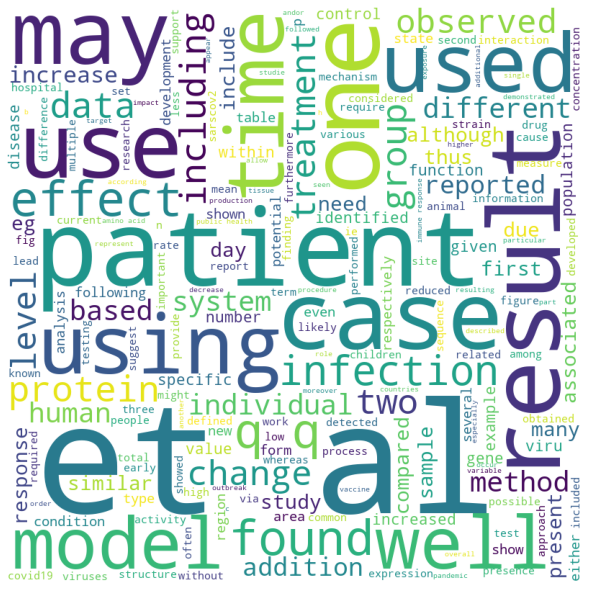

In [55]:
comment_words = '' 
i = 0
for val in bodytext[30000:32000]: 
    val = str(val) 
    tokens = val.split()       
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

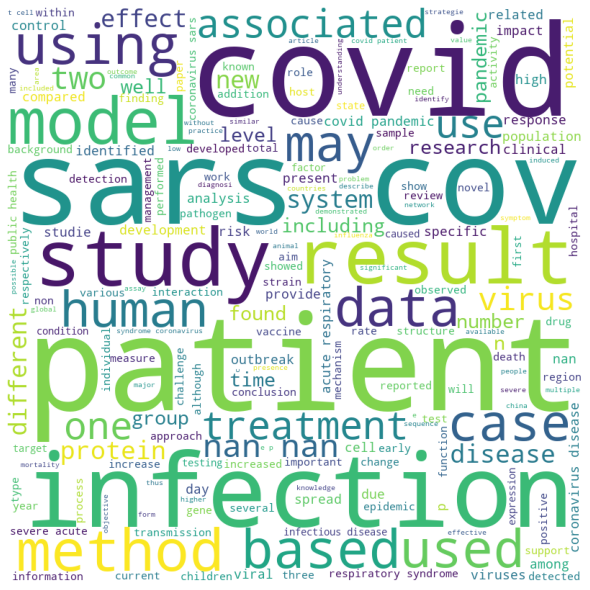

In [56]:
comment_words = '' 
i = 0
for val in df.abstract: 
    val = str(val) 
    tokens = val.split()       
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

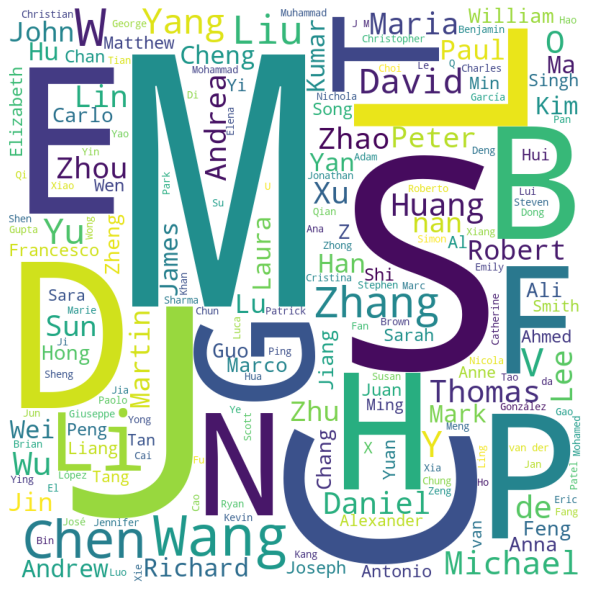

In [57]:
comment_words = '' 

for val in df.authors: 
    val = str(val) 
    tokens = val.split()       
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [59]:
df['body_nonnumeric'] = df['body'].str.replace('\d+', '').astype(str)

In [60]:
bodytext = []
for index, row in df.iterrows():
  bodytext.append(row['body_nonnumeric'])

In [61]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [62]:
tokenizer.fit_on_texts(bodytext)

In [64]:
word_index = tokenizer.word_index
print(len(word_index))

1489168


In [65]:
seq = tokenizer.texts_to_sequences(bodytext[:20000])

In [66]:
seq1 = tokenizer.texts_to_sequences(bodytext[20000:])

In [67]:
max_length = 500
trunc_type='post'
padding_type='post'

In [68]:
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [69]:
padded1 = pad_sequences(seq1, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [128]:
model = KMeans(n_clusters=2,init='k-means++')

In [129]:
ypred = model.fit_predict(padded)

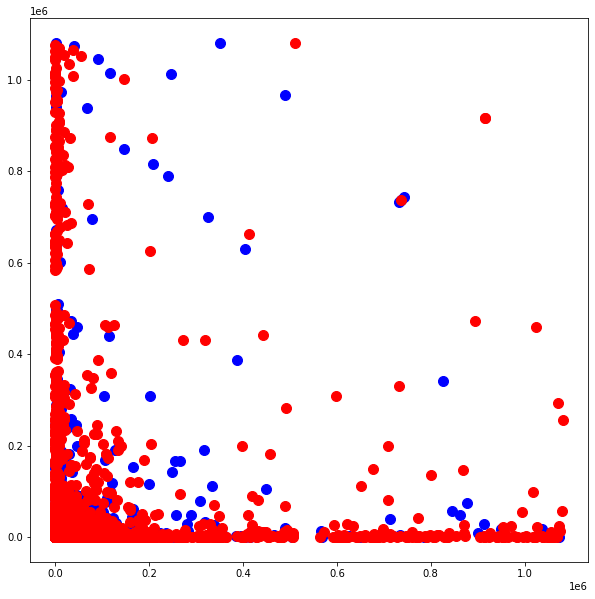

In [130]:
plt.figure(figsize=(10,10))
plt.scatter(padded[ypred==0, 0], padded[ypred==0, 1], s =100, c = 'blue', label='cluster 1')
plt.scatter(padded[ypred==1, 0], padded[ypred==1, 1], s =100, c = 'red', label='cluster 2')
plt.show()

In [131]:
ypred = model.fit_predict(padded1)

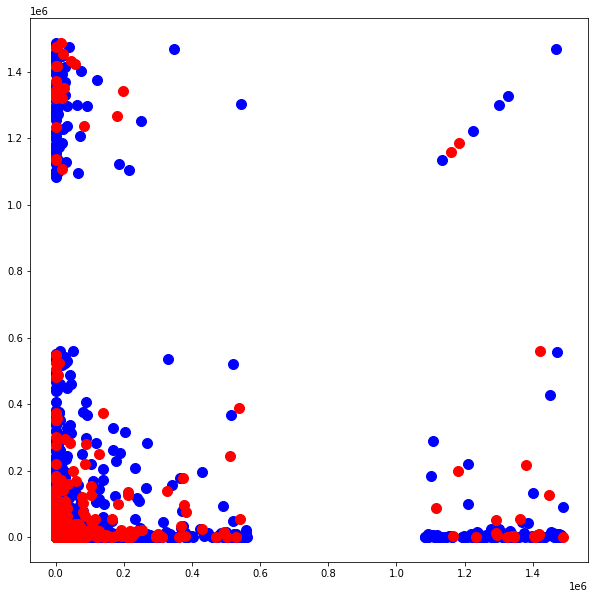

In [132]:
plt.figure(figsize=(10,10))
plt.scatter(padded1[ypred==0, 0], padded1[ypred==0, 1], s =100, c = 'blue', label='cluster 1')
plt.scatter(padded1[ypred==1, 0], padded1[ypred==1, 1], s =100, c = 'red', label='cluster 2')
#plt.scatter(padded1[ypred==2, 0], padded1[ypred==2, 1], s =100, c = 'green', label='cluster 3')
plt.show()

In [95]:
titletext = df[df['title_x'].notnull()]['title_x']
token = Tokenizer(oov_token="<OOV>")
token.fit_on_texts(titletext)

In [96]:
titseq = tokenizer.texts_to_sequences(titletext)
paddedtitle = pad_sequences(titseq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [116]:
modeltitle = KMeans(n_clusters=2,init='k-means++')
ypred = model.fit_predict(paddedtitle)

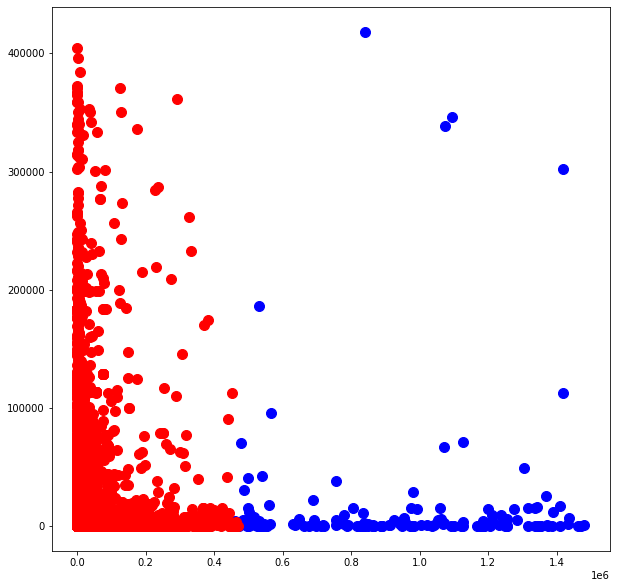

In [117]:
plt.figure(figsize=(10,10))
plt.scatter(paddedtitle[ypred==0, 0], paddedtitle[ypred==0, 1], s =100, c = 'blue', label='cluster 1')
plt.scatter(paddedtitle[ypred==1, 0], paddedtitle[ypred==1, 1], s =100, c = 'red', label='cluster 2')
#plt.scatter(paddedtitle[ypred==2, 0], paddedtitle[ypred==2, 1], s =100, c = 'green', label='cluster 3')
plt.show()

In [99]:
abstext = df[df['abstract'].notnull()]['abstract']
tokenabs = Tokenizer(oov_token="<OOV>")
token.fit_on_texts(abstext)

In [100]:
absseq = tokenizer.texts_to_sequences(titletext)
paddedabs = pad_sequences(absseq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [114]:
modelabs = KMeans(n_clusters=2,init='k-means++')
ypred = model.fit_predict(paddedabs)

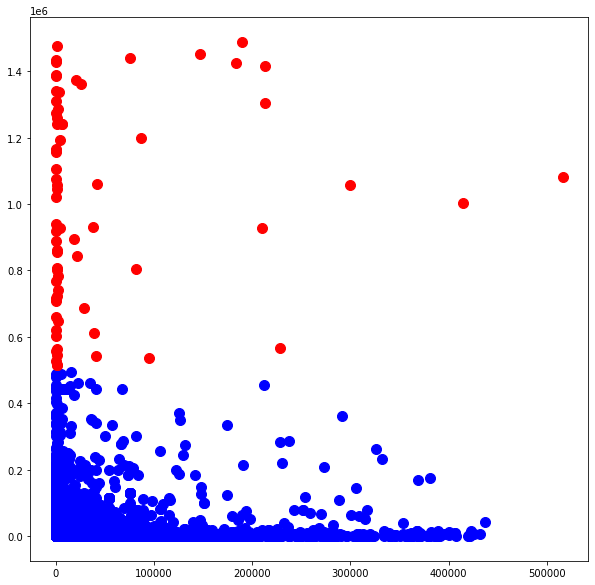

In [115]:
plt.figure(figsize=(10,10))
plt.scatter(paddedabs[ypred==0, 0], paddedabs[ypred==0, 1], s =100, c = 'blue', label='cluster 1')
plt.scatter(paddedabs[ypred==1, 0], paddedabs[ypred==1, 1], s =100, c = 'red', label='cluster 2')
plt.scatter(paddedabs[ypred==2, 0], paddedabs[ypred==2, 1], s =100, c = 'green', label='cluster 3')

plt.show()

In [103]:
x = df[["abstract_word_count","body_word_count","body_unique_words","avg_word","numerics"]].values

In [104]:
y = df['stopwords'].values

In [105]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [106]:
reg = LinearRegression().fit(X_train, y_train)

In [107]:
reg.score(X_test, y_test)

0.9834973609186985

In [108]:
reg.coef_

array([ 1.12124508e-01,  3.68553292e-01, -1.13594320e-01, -2.00896918e+02,
       -9.22305172e-01])

In [109]:
reg.intercept_

1215.4242039659832

In [110]:
bcount = df[['body_word_count', 'body_unique_words']].values

In [112]:
modelbcount = KMeans(n_clusters=3,init='k-means++')
ypred = model.fit_predict(bcount)

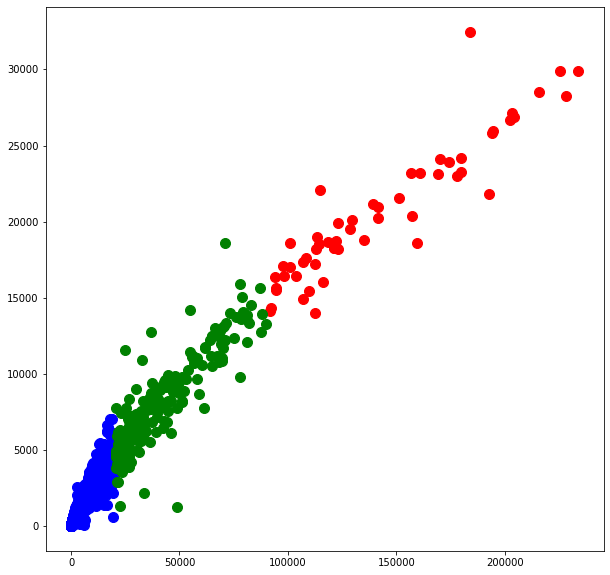

In [113]:
plt.figure(figsize=(10,10))
plt.scatter(bcount[ypred==0, 0], bcount[ypred==0, 1], s =100, c = 'blue', label='cluster 1')
plt.scatter(bcount[ypred==1, 0], bcount[ypred==1, 1], s =100, c = 'red', label='cluster 2')
plt.scatter(bcount[ypred==2, 0], bcount[ypred==2, 1], s =100, c = 'green', label='cluster 3')
plt.show()